In [3]:
import json
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from math import copysign as sgn
%matplotlib inline  

In [56]:
# data manipulation functions
def number_of_tests():
    return len(os.listdir('tests'))

def clear_tests():
    for i in os.listdir('tests'):
        os.remove('tests/{0}'.format(i))

def load_all_tests(num):
    test_name = 1
    for root, dirs, files in os.walk('all_tests/test_{0}'.format(num)):
        for file in files:
            if file != '1.test':
                shutil.copyfile('{0}/{1}'.format(root, file), 'tests/{0}.test'.format(test_name))
                test_name += 1

def load_test(num):
    jsObj = open("tests/{0}.test".format(num), "r")
    testObj = json.load(jsObj)
    jsObj.close()
    return testObj

In [61]:
# parameters extracting

# -------- Functions for static experiments
def distance(x1, y1, x2, y2):
    return ((x1-x2)**2 + (y1-y2)**2)**(1/2)

def velocity(arr, num):
    try:
        return distance(arr[num]['x'], arr[num]['y'], arr[num-1]['x'], arr[num-1]['y']) / (arr[num]['time'] - arr[num-1]['time'])
    except:
        return 0

def first_distance(obj):
    return distance(obj['ballX'], obj['ballY'], obj['data'][0]['x'], obj['data'][0]['y'])

def searching_delay(obj):
    garanted_find = min(20, len(obj['data'])-1)
    barrier_velocity = 0.5 #px/msec
    for i in range(garanted_find):
        if velocity(obj['data'], i+1) > barrier_velocity:
            return obj['data'][i+1]['time']
    return obj['data'][garanted_find]['time']

def all_distance(obj):
    result = 0
    for i in range(1, len(obj['data'])):
        result += distance(obj['data'][i]['x'], obj['data'][i]['y'], obj['data'][i-1]['x'], obj['data'][i-1]['y'])
    return result

def all_time(obj):
    return obj['data'][-1]['time']

def average_velocity(obj):
    return all_distance(obj) / all_time(obj)

def max_deviation(obj):
    maximum = 0
    
    x1, y1 = (obj['data'][0]['x'], obj['data'][0]['y'])
    x2, y2 = (obj['ballX'], obj['ballY'])
    
    A = (y2-y1)/(x1*y2-x2*y1)
    B = (x1-x2)/(x1*y2-x2*y1)
    H = lambda v: abs(A*v[0]+B*v[1]-1)/( (A**2 + B**2)**(1/2) ) #x = v[0], y = v[1]
    
    for i in obj['data']:
        maximum = max(maximum, H([i['x'], i['y']]))
    
    return maximum

def inertion(obj): # length, time
    x0, y0, R = (obj['ballX'], obj['ballY'], obj['ballSize'])
    max_len = 0
    in_ball = lambda x, y: (x-x0)**2+(y-y0)**2 < max(R, 50)**2
    
    first_intersect = -1
    for i in range(len(obj['data'])):
        if in_ball(obj['data'][i]['x'], obj['data'][i]['y']):
            first_intersect = i
            break
    if first_intersect < 0:
        return (0, 0)
    
    point = first_intersect # первое пересечение с шариком
    while point < len(obj['data']) and in_ball(obj['data'][point]['x'], obj['data'][point]['y']):
        point += 1
    if point == len(obj['data']):
        return (0, 0)
    
    second_intersect = point # второе пересечение - вылет из шарика из-за инерции
    while point < len(obj['data']) and not in_ball(obj['data'][point]['x'], obj['data'][point]['y']):
        max_len = max(max_len, distance(obj['data'][point]['x'], obj['data'][point]['y'], x0, y0))
        point += 1
    if point == len(obj['data']):
        return (max_len, obj['data'][second_intersect]['time']-obj['data'][first_intersect]['time'])
    
    third_intersect = point # третье пересечение - возвражение обратно в шарик (корректировка)
    return (max_len, obj['data'][third_intersect]['time']-obj['data'][second_intersect]['time'])

def right_or_left(obj):
    if obj['data'][0]['x'] > obj['ballX']:
        return 1
    else:
        return -1
    
#----- Functions for dynamic experiments

def max_deviation_d(obj): # +, если прошел по верху, -, если прошел по низу
    maximum = 0
    minimum = 0
    
    x1, y1 = (obj['data'][0]['x'], obj['data'][0]['y'])
    x2, y2 = (lambda n: obj['ballData'][n]['x'], lambda n: obj['ballData'][n]['y'])
    
    A = lambda n: (y2(n)-y1)/(x1*y2(n)-x2(n)*y1)
    B = lambda n: (x1-x2(n))/(x1*y2(n)-x2(n)*y1)
    H = lambda v, n: (A(n)*v[0]+B(n)*v[1]-1)/( (A(n)**2 + B(n)**2)**(1/2) ) #x = v[0], y = v[1]
    
    for i in range(len(obj['data'])):
        h = H([obj['data'][i]['x'], obj['data'][i]['y']], i)
        maximum = max(maximum, h)
        minimum = min(minimum, h)
    
    if(abs(minimum) > maximum):
        return minimum
    else:
        return maximum

def ball_velocity(obj):
    try:
        return distance(obj['ballData'][0]['x'], obj['ballData'][0]['y'], obj['ballData'][1]['x'], obj['ballData'][1]['y'])/(obj['ballData'][1]['time']-obj['ballData'][0]['time'])
    except:
        return 0
    
def correl(obj):
    bx, by = (obj['ballData'][1]['x']-obj['ballData'][0]['x'], obj['ballData'][1]['y']-obj['ballData'][0]['y'])
    x, y = (obj['data'][1]['x']-obj['data'][0]['x'], obj['data'][1]['y']-obj['data'][0]['y'])
    return sgn(1, bx*x + by*y)

def scalar(obj, i, j):
    return (obj['data'][i]['x']-obj['data'][i-1]['x'])*(obj['data'][j]['x']-obj['data'][j-1]['x']) + (obj['data'][i]['y']-obj['data'][i-1]['y'])*(obj['data'][j]['y']-obj['data'][j-1]['y'])

def scal_cos(obj, i, j):
    try:
        return scalar(obj, i, j)/(scalar(obj, i, i)*scalar(obj, j, j))**(1/2)
    except:
        return 0

def deviation_coef(obj, i, j):
    return 1+( abs( scal_cos(obj, i, j) -1)/2 )**(1/2)

def delay_d(obj):
    barrier_value = 0.3
    for i in range(1, len(obj['data'])-1):
        if velocity(obj['data'], i+1)*deviation_coef(obj, i+1, i) > barrier_value:
            return obj['data'][i]['time']
    return 0 # пользователь не подал признаков того, что он нашел, значит в предположении, он сразу его увидел

def inertion_d(obj): # length, time
    x0, y0, R = (lambda x: obj['ballData'][x]['x'], lambda x: obj['ballData'][x]['y'], obj['ballSize'])
    max_len = 0
    in_ball = lambda x, y, p: (x-x0(p))**2+(y-y0(p))**2 < max(R, 50)**2
    
    first_intersect = -1
    for i in range(len(obj['data'])):
        if in_ball(obj['data'][i]['x'], obj['data'][i]['y'], i):
            first_intersect = i
            break
    if first_intersect < 0:
        return (0, 0)
    
    point = first_intersect # первое пересечение с шариком
    while point < len(obj['data']) and in_ball(obj['data'][point]['x'], obj['data'][point]['y'], point):
        point += 1
    if point == len(obj['data']):
        return (0, 0)
    
    second_intersect = point # второе пересечение - вылет из шарика из-за инерции
    while point < len(obj['data']) and not in_ball(obj['data'][point]['x'], obj['data'][point]['y'], point):
        max_len = max(max_len, distance(obj['data'][point]['x'], obj['data'][point]['y'], x0(point), y0(point)))
        point += 1
    if point == len(obj['data']):
        return (max_len, obj['data'][second_intersect]['time']-obj['data'][first_intersect]['time'])
    
    third_intersect = point # третье пересечение - возвражение обратно в шарик (корректировка)
    return (max_len, obj['data'][third_intersect]['time']-obj['data'][second_intersect]['time'])
    
#----- Agreration Data -----------

# Перед тем как использовать эту функцию, убедитесь, что в папку all_tests загруженны все ваши тесты
def get_test_data(number):
    clear_tests()
    load_all_tests(number)
    raw_data = [load_test(x) for x in range(1, number_of_tests())]
    functions = [
        [lambda x: x['ballX'], lambda x: x['ballY'], lambda x: x['ballSize'], right_or_left, first_distance, all_distance, searching_delay, all_time, average_velocity, max_deviation, lambda x: inertion(x)[0], lambda x: inertion(x)[1], lambda x: x['shots']],
        [lambda x: x['ballX'], lambda x: x['ballY'], lambda x: x['ballSize'], first_distance, ball_velocity, correl, all_distance, all_time, average_velocity, lambda x: abs(max_deviation_d(x)), lambda x: sgn(1, max_deviation_d(x)), delay_d, lambda x: inertion_d(x)[0], lambda x: inertion_d(x)[1]]
    ]
    cols = [
        ['BallX', 'BallY', 'BallSize', 'RorL', 'FirstDist', 'AllDist', 'Delay', 'AllTime', 'AverVelocity', 'MaxDev', 'InerLen', 'InerTime', 'Shots'],
        ['BallX', 'BallY', 'BallSize', 'FirstDist', 'BallVelocity', 'Correlation', 'AllDist', 'AllTime', 'AverVelocity', 'AbsMaxDev', 'UpOrDown', 'Delay', 'InerLen', 'InerTime']
    ]
    return pd.DataFrame.from_records([[f(x) for f in functions[number-1]] for x in raw_data], columns=cols[number-1])

In [6]:
a = load_test(20)
print(all_distance(a))
print(all_time(a))
print(average_velocity(a))
print(max_deviation(a))
print(inertion(a))

1173.9240676202107
1900
0.6178547724316898
514.1965709216322
(0, 0)


In [7]:
data1 = get_test_data(1)
data1 = data1[data1.AllTime < 5000]
data1.head()

,BallX,BallY,BallSize,RorL,FirstDist,AllDist,Delay,AllTime,AverVelocity,MaxDev,InerLen,InerTime,Shots
0,999,262,89,-1,556.742310,650.458519,212,644,1.010029,61.832915,0.000000,0,1
1,944,142,121,-1,299.006689,1010.566589,289,2255,0.448145,80.252385,0.000000,0,1
2,1114,488,141,-1,831.892421,1372.881169,160,1078,1.273545,108.612601,307.026058,386,1
4,695,119,37,-1,569.227547,684.868823,229,993,0.689697,140.179442,0.000000,0,1
5,936,257,6,1,453.045252,562.351809,167,1707,0.329439,58.678465,0.000000,0,1


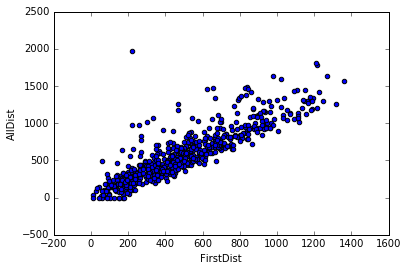

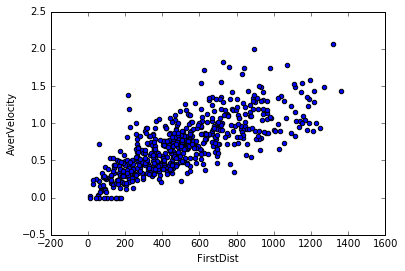

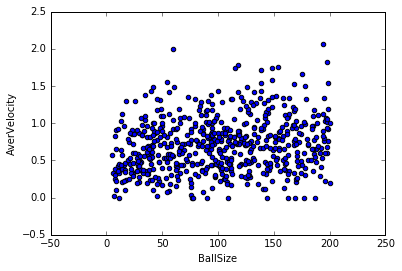

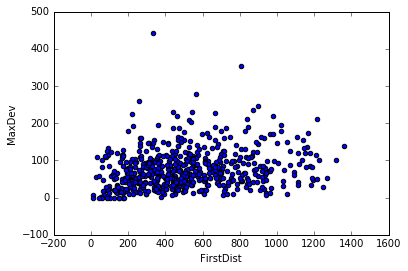

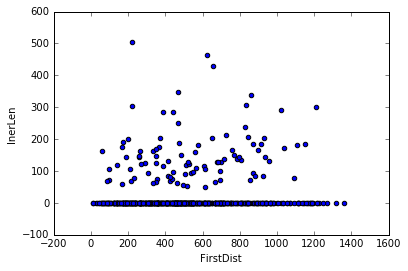

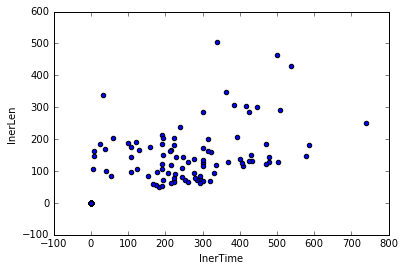

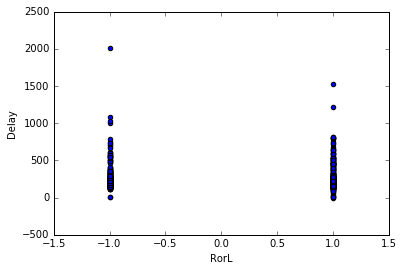

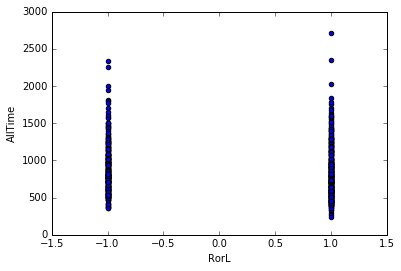

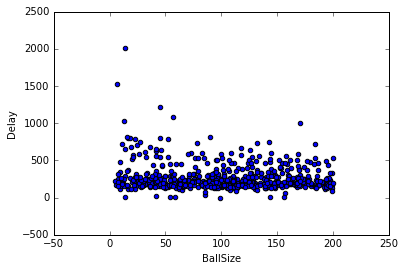

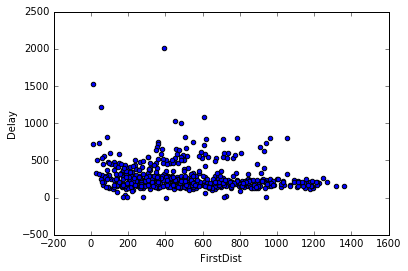

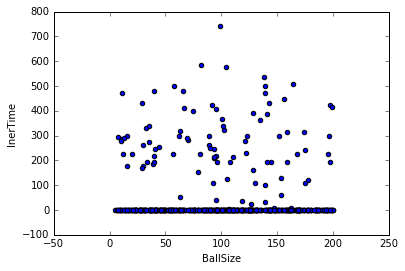

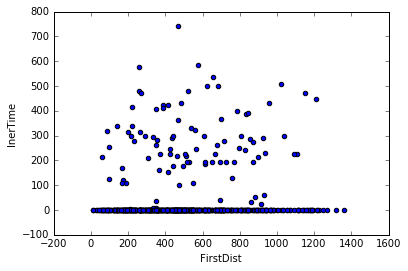

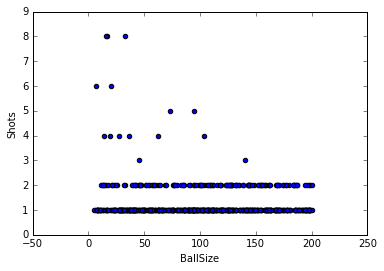

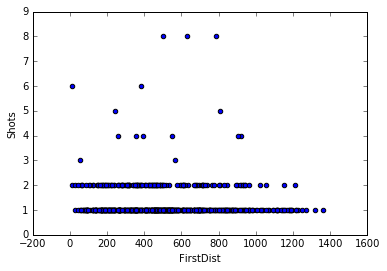

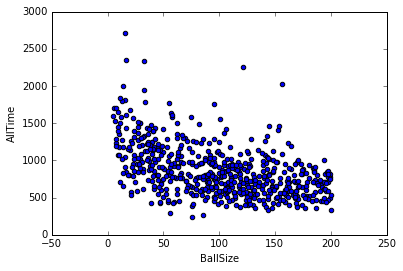

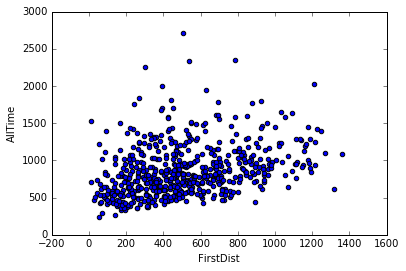

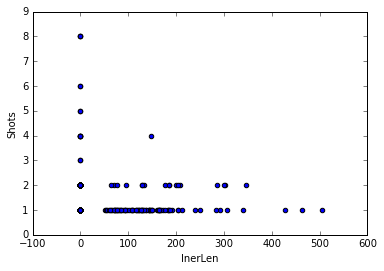

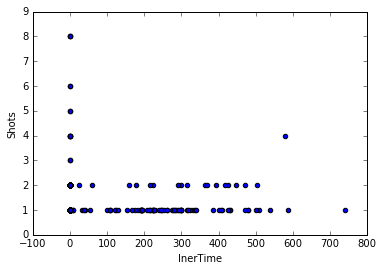

In [8]:
data1.plot.scatter(x='FirstDist', y='AllDist')
data1.plot.scatter(x='FirstDist', y='AverVelocity')
data1.plot.scatter(x='BallSize', y='AverVelocity')
data1.plot.scatter(x='FirstDist', y='MaxDev')
data1.plot.scatter(x='FirstDist', y='InerLen')
data1.plot.scatter(x='InerTime', y='InerLen')
data1.plot.scatter(x='RorL', y='Delay')
data1.plot.scatter(x='RorL', y='AllTime')
data1.plot.scatter(x='BallSize', y='Delay')
data1.plot.scatter(x='FirstDist', y='Delay')
data1.plot.scatter(x='BallSize', y='InerTime')
data1.plot.scatter(x='FirstDist', y='InerTime')
data1.plot.scatter(x='BallSize', y='Shots')
data1.plot.scatter(x='FirstDist', y='Shots')
data1.plot.scatter(x='BallSize', y='AllTime')
data1.plot.scatter(x='FirstDist', y='AllTime')
data1.plot.scatter(x='InerLen', y='Shots')
data1.plot.scatter(x='InerTime', y='Shots')

In [9]:
from sklearn import linear_model
pparams = ['AllDist', 'Delay', 'AllTime', 'AverVelocity', 'MaxDev', 'InerLen', 'InerTime', 'Shots']

regs = {}
for p in pparams:
    regs[p] = linear_model.LinearRegression()
    regs[p].fit(data1[['BallSize', 'FirstDist']], data1[p])

def predict(size, dist):
    for p in regs.keys():
        print(p, ": ", regs[p].predict([size, dist])[0])
        
def print_regs():
    for p in regs.keys():
        print("{0:<12} = {1:<8.5} + {2:<8.3} * Size + {3:<9.3} * Distantion".format(p, regs[p].intercept_, regs[p].coef_[0], regs[p].coef_[1]))

print_regs()

AllTime      = 973.78   + -3.03    * Size + 0.38      * Distantion
AverVelocity = 0.036215 + 0.0016   * Size + 0.001     * Distantion
MaxDev       = 21.608   + 0.32     * Size + 0.0448    * Distantion
InerTime     = 35.905   + -0.0581  * Size + 0.0244    * Distantion
Shots        = 1.5448   + -0.00152 * Size + -0.000156 * Distantion
AllDist      = 72.029   + -0.271   * Size + 1.09      * Distantion
Delay        = 362.43   + -0.39    * Size + -0.102    * Distantion
InerLen      = 0.54318  + 0.134    * Size + 0.02      * Distantion


In [10]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)


pparams = ['AllDist', 'Delay', 'AllTime', 'AverVelocity', 'MaxDev', 'InerLen', 'InerTime', 'Shots']

regsp = {}
for p in pparams:
    regsp[p] = linear_model.LinearRegression()
    regsp[p].fit(poly.fit_transform(data1[['BallSize', 'FirstDist']]), data1[p])

In [11]:
predict(90, 550)
print("-"*10)
for p in pparams:
    print(p, " : ", regsp[p].predict(poly.fit_transform([[90, 550]])[0])[0])
data1.head()

AllTime :  909.574181275
AverVelocity :  0.73060788897
MaxDev :  75.0246720811
InerTime :  44.0899450297
Shots :  1.32233431496
AllDist :  648.691627778
Delay :  271.454627621
InerLen :  23.5657267953
----------
AllDist  :  645.336994924
Delay  :  245.628775593
AllTime  :  854.583472876
AverVelocity  :  0.790967289885
MaxDev  :  76.2893004973
InerLen  :  24.9074485404
InerTime  :  48.1816771446
Shots  :  1.25712235559


/home/vagrant/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/vagrant/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/vagrant/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single s

,BallX,BallY,BallSize,RorL,FirstDist,AllDist,Delay,AllTime,AverVelocity,MaxDev,InerLen,InerTime,Shots
0,999,262,89,-1,556.742310,650.458519,212,644,1.010029,61.832915,0.000000,0,1
1,944,142,121,-1,299.006689,1010.566589,289,2255,0.448145,80.252385,0.000000,0,1
2,1114,488,141,-1,831.892421,1372.881169,160,1078,1.273545,108.612601,307.026058,386,1
4,695,119,37,-1,569.227547,684.868823,229,993,0.689697,140.179442,0.000000,0,1
5,936,257,6,1,453.045252,562.351809,167,1707,0.329439,58.678465,0.000000,0,1


In [12]:
for i in pparams:
    print(i, " : ", data1['RorL'].corr(data1[i], method='pearson'))
    
rorl = linear_model.LinearRegression()

p = "RorL"

rorl.fit(data1[['BallSize', 'FirstDist']], data1[p])

print("{0:<12} = {1:<8.5} + {2:<8.3} * Size + {3:<9.3} * Distantion".format(p, rorl.intercept_, rorl.coef_[0], rorl.coef_[1]))

AllDist  :  -0.112081128814
Delay  :  0.0100508459643
AllTime  :  -0.086333771138
AverVelocity  :  -0.104623984595
MaxDev  :  -0.134595951175
InerLen  :  -0.123790948141
InerTime  :  -0.106976738295
Shots  :  0.0432156371795
RorL         = 0.066416 + 0.000454 * Size + 3.16e-05  * Distantion


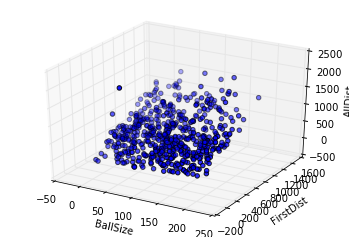

In [13]:
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure().gca(projection='3d')
threedee.scatter(data1['BallSize'], data1['FirstDist'], data1['AllDist'])
threedee.set_xlabel('BallSize')
threedee.set_ylabel('FirstDist')
threedee.set_zlabel('AllDist')
plt.show()

In [40]:
load_all_tests(1)
t = load_test(7)
# print(average_velocity(t))
#print(first_distance(t))
# print(max_deviation_d(t))

In [63]:
data2 = get_test_data(2)
data2[:100]

,BallX,BallY,BallSize,FirstDist,BallVelocity,Correlation,AllDist,AllTime,AverVelocity,AbsMaxDev,UpOrDown,Delay,InerLen,InerTime
0,1146,441,68,535.934698,0.200000,-1.0,892.209932,3907,0.228362,82.992265,-1.0,2552,156.706732,570
1,1015,353,126,608.112654,0.172005,1.0,751.787970,828,0.907956,289.474126,1.0,126,0.000000,0
2,703,331,81,292.882229,0.000000,1.0,420.736427,2602,0.161697,131.727542,-1.0,1746,0.000000,0
3,1010,57,172,166.355042,0.257694,-1.0,691.904280,1150,0.601656,119.937823,1.0,228,0.000000,0
4,254,465,136,543.261447,0.392232,1.0,727.475459,1626,0.447402,317.920931,1.0,659,0.000000,0
5,103,204,70,932.035407,0.110423,-1.0,1197.392487,1542,0.776519,306.290676,1.0,147,0.000000,0
6,803,45,96,357.302393,0.375000,-1.0,618.061663,6113,0.101106,104.202003,-1.0,4844,0.000000,0
7,870,403,43,459.009804,0.225347,1.0,698.531551,1947,0.358773,58.977597,-1.0,1131,0.000000,0
8,237,534,33,312.385979,0.200308,1.0,498.037622,2524,0.197321,113.140287,1.0,1365,0.000000,0
9,312,457,151,570.788928,0.000000,1.0,1698.850363,2862,0.593589,408.551520,-1.0,941,0.000000,0
